Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
# Maplotlib and numpy 
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import scipy.io
# Tensorflow
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import funs
# Lorenz attractor
from Lorenz_Attractor import sample_traj_lorenz

# Sample from latent Lorenz attractor:


In [2]:
Time = 500
neuron_num = 30
traj = sample_traj_lorenz(T = Time,speed_up = 4,initial_offset = 10000)
datax = scipy.io.loadmat("xtrain_hati20.mat")
y_data = datax["yy"] 
#traj = scipy.io.loadmat("trj_hati.mat")
#traj = traj["xxhati"]
traj = scipy.io.loadmat("trj_hati_k09.mat")
traj = traj["trj"].T

[[-0.09136076  6.9178786  -0.251625   ... -0.09785359 -0.31170198
  -0.23226742]
 [-0.09136076  1.2575387  -0.251625   ...  1.9694756  -0.31170198
  -0.23226742]
 [-0.09136076  6.9178786  -0.251625   ...  0.59125614 -0.31170198
  -0.23226742]
 ...
 [-0.09136076  6.9178786  -0.251625   ... -0.09785359 -0.31170198
  -0.23226742]
 [-0.09136076  0.31414884 -0.251625   ...  0.59125614 -0.31170198
  -0.23226742]
 [-0.09136076 -0.15754612 -0.251625   ...  2.6585853  -0.31170198
  -0.23226742]]


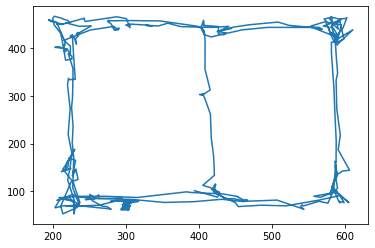

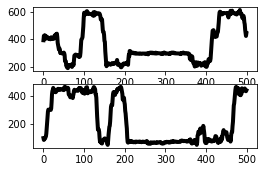

In [3]:
factor_dim = 2
Factor = np.random.randn(factor_dim,neuron_num)

NRep=1
output = np.zeros((NRep,Time,neuron_num))

for i in range(NRep):
    output[i,:,:] = y_data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0])

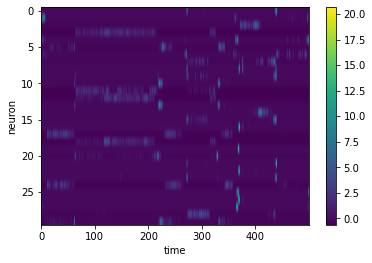

In [4]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('time')
plt.ylabel('neuron')
plt.colorbar()
plt.show()

In [5]:
# Create Tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((output))
dataset = dataset.shuffle(20, reshuffle_each_iteration=True)

# Autoencoder Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        self.dense_output = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        xo = self.dense_output(x)
        return xo, x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=2,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)[0]
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    def latent(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        latent = self.decoder(z)[1]
        return latent

In [11]:
BATCH_SIZE = 20
batched_dataset = dataset.batch(BATCH_SIZE)

In [12]:
vae = VariationalAutoEncoder(latent_dim=64,
                             num_gru_unit=128,
                             sequence_length=Time,
                             num_input_neuron=neuron_num,
                             num_factor=2)

# Train Model

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [14]:
KL_penalty = np.linspace(0,1,3)

In [15]:
epochs = 2000

for i,kl_ in enumerate(KL_penalty):
    
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:
                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))

Start of epoch 0
step 0: mean loss = 1.0003672
Start of epoch 1
step 0: mean loss = 0.99991775
Start of epoch 2
step 0: mean loss = 0.99977374
Start of epoch 3
step 0: mean loss = 0.9996596
Start of epoch 4
step 0: mean loss = 0.99958783
Start of epoch 5
step 0: mean loss = 0.99959034
Start of epoch 6
step 0: mean loss = 0.99957544
Start of epoch 7
step 0: mean loss = 0.99949944
Start of epoch 8
step 0: mean loss = 0.99942327
Start of epoch 9
step 0: mean loss = 0.9993426
Start of epoch 10
step 0: mean loss = 0.9992519
Start of epoch 11
step 0: mean loss = 0.99920535
Start of epoch 12
step 0: mean loss = 0.99909824
Start of epoch 13
step 0: mean loss = 0.9990183
Start of epoch 14
step 0: mean loss = 0.9990704
Start of epoch 15
step 0: mean loss = 0.99897933
Start of epoch 16
step 0: mean loss = 0.99899596
Start of epoch 17
step 0: mean loss = 0.99891067
Start of epoch 18
step 0: mean loss = 0.998838
Start of epoch 19
step 0: mean loss = 0.99874324
Start of epoch 20
step 0: mean loss = 

step 0: mean loss = 0.97655845
Start of epoch 169
step 0: mean loss = 0.9763732
Start of epoch 170
step 0: mean loss = 0.97618854
Start of epoch 171
step 0: mean loss = 0.9760043
Start of epoch 172
step 0: mean loss = 0.97581995
Start of epoch 173
step 0: mean loss = 0.97563636
Start of epoch 174
step 0: mean loss = 0.9754539
Start of epoch 175
step 0: mean loss = 0.97527194
Start of epoch 176
step 0: mean loss = 0.9750903
Start of epoch 177
step 0: mean loss = 0.97490907
Start of epoch 178
step 0: mean loss = 0.9747288
Start of epoch 179
step 0: mean loss = 0.97454995
Start of epoch 180
step 0: mean loss = 0.9743713
Start of epoch 181
step 0: mean loss = 0.9741932
Start of epoch 182
step 0: mean loss = 0.9740157
Start of epoch 183
step 0: mean loss = 0.97383904
Start of epoch 184
step 0: mean loss = 0.97366375
Start of epoch 185
step 0: mean loss = 0.97348917
Start of epoch 186
step 0: mean loss = 0.97331566
Start of epoch 187
step 0: mean loss = 0.9731428
Start of epoch 188
step 0: m

step 0: mean loss = 0.95739263
Start of epoch 335
step 0: mean loss = 0.95732963
Start of epoch 336
step 0: mean loss = 0.957267
Start of epoch 337
step 0: mean loss = 0.9572047
Start of epoch 338
step 0: mean loss = 0.9571427
Start of epoch 339
step 0: mean loss = 0.9570811
Start of epoch 340
step 0: mean loss = 0.9570197
Start of epoch 341
step 0: mean loss = 0.9569588
Start of epoch 342
step 0: mean loss = 0.95689815
Start of epoch 343
step 0: mean loss = 0.9568378
Start of epoch 344
step 0: mean loss = 0.95677775
Start of epoch 345
step 0: mean loss = 0.95671797
Start of epoch 346
step 0: mean loss = 0.95665854
Start of epoch 347
step 0: mean loss = 0.9565994
Start of epoch 348
step 0: mean loss = 0.9565407
Start of epoch 349
step 0: mean loss = 0.9564822
Start of epoch 350
step 0: mean loss = 0.95642406
Start of epoch 351
step 0: mean loss = 0.9563661
Start of epoch 352
step 0: mean loss = 0.9563085
Start of epoch 353
step 0: mean loss = 0.95625114
Start of epoch 354
step 0: mean 

step 0: mean loss = 0.95485437
Start of epoch 501
step 0: mean loss = 0.9548441
Start of epoch 502
step 0: mean loss = 0.9548276
Start of epoch 503
step 0: mean loss = 0.9548089
Start of epoch 504
step 0: mean loss = 0.95478874
Start of epoch 505
step 0: mean loss = 0.9547674
Start of epoch 506
step 0: mean loss = 0.95474416
Start of epoch 507
step 0: mean loss = 0.95471984
Start of epoch 508
step 0: mean loss = 0.9546956
Start of epoch 509
step 0: mean loss = 0.954671
Start of epoch 510
step 0: mean loss = 0.95464456
Start of epoch 511
step 0: mean loss = 0.9546181
Start of epoch 512
step 0: mean loss = 0.9545912
Start of epoch 513
step 0: mean loss = 0.9545633
Start of epoch 514
step 0: mean loss = 0.95453477
Start of epoch 515
step 0: mean loss = 0.95450646
Start of epoch 516
step 0: mean loss = 0.95447755
Start of epoch 517
step 0: mean loss = 0.95444846
Start of epoch 518
step 0: mean loss = 0.9544187
Start of epoch 519
step 0: mean loss = 0.95438874
Start of epoch 520
step 0: mea

step 0: mean loss = 0.94912916
Start of epoch 667
step 0: mean loss = 0.94905704
Start of epoch 668
step 0: mean loss = 0.9489815
Start of epoch 669
step 0: mean loss = 0.9488957
Start of epoch 670
step 0: mean loss = 0.94881916
Start of epoch 671
step 0: mean loss = 0.9487338
Start of epoch 672
step 0: mean loss = 0.9486521
Start of epoch 673
step 0: mean loss = 0.94856495
Start of epoch 674
step 0: mean loss = 0.9484823
Start of epoch 675
step 0: mean loss = 0.94839334
Start of epoch 676
step 0: mean loss = 0.94830763
Start of epoch 677
step 0: mean loss = 0.94821805
Start of epoch 678
step 0: mean loss = 0.9481308
Start of epoch 679
step 0: mean loss = 0.94804007
Start of epoch 680
step 0: mean loss = 0.9479511
Start of epoch 681
step 0: mean loss = 0.94786173
Start of epoch 682
step 0: mean loss = 0.9477704
Start of epoch 683
step 0: mean loss = 0.9476818
Start of epoch 684
step 0: mean loss = 0.94759065
Start of epoch 685
step 0: mean loss = 0.9475006
Start of epoch 686
step 0: me

step 0: mean loss = 0.9354836
Start of epoch 834
step 0: mean loss = 0.9354122
Start of epoch 835
step 0: mean loss = 0.93534094
Start of epoch 836
step 0: mean loss = 0.93526953
Start of epoch 837
step 0: mean loss = 0.9351981
Start of epoch 838
step 0: mean loss = 0.935127
Start of epoch 839
step 0: mean loss = 0.93505603
Start of epoch 840
step 0: mean loss = 0.93498564
Start of epoch 841
step 0: mean loss = 0.9349232
Start of epoch 842
step 0: mean loss = 0.9348674
Start of epoch 843
step 0: mean loss = 0.93481064
Start of epoch 844
step 0: mean loss = 0.9347436
Start of epoch 845
step 0: mean loss = 0.9346845
Start of epoch 846
step 0: mean loss = 0.93461615
Start of epoch 847
step 0: mean loss = 0.9345546
Start of epoch 848
step 0: mean loss = 0.93448687
Start of epoch 849
step 0: mean loss = 0.9344247
Start of epoch 850
step 0: mean loss = 0.93435794
Start of epoch 851
step 0: mean loss = 0.93429446
Start of epoch 852
step 0: mean loss = 0.93422955
Start of epoch 853
step 0: mea

step 0: mean loss = 0.9255045
Start of epoch 1001
step 0: mean loss = 0.9254537
Start of epoch 1002
step 0: mean loss = 0.925403
Start of epoch 1003
step 0: mean loss = 0.92535174
Start of epoch 1004
step 0: mean loss = 0.9253001
Start of epoch 1005
step 0: mean loss = 0.92524827
Start of epoch 1006
step 0: mean loss = 0.9251963
Start of epoch 1007
step 0: mean loss = 0.9251443
Start of epoch 1008
step 0: mean loss = 0.9250924
Start of epoch 1009
step 0: mean loss = 0.9250406
Start of epoch 1010
step 0: mean loss = 0.92498904
Start of epoch 1011
step 0: mean loss = 0.92493796
Start of epoch 1012
step 0: mean loss = 0.92488754
Start of epoch 1013
step 0: mean loss = 0.9248376
Start of epoch 1014
step 0: mean loss = 0.9247876
Start of epoch 1015
step 0: mean loss = 0.9247371
Start of epoch 1016
step 0: mean loss = 0.9246862
Start of epoch 1017
step 0: mean loss = 0.9246351
Start of epoch 1018
step 0: mean loss = 0.924584
Start of epoch 1019
step 0: mean loss = 0.92453295
Start of epoch 1

step 0: mean loss = 0.9176814
Start of epoch 1164
step 0: mean loss = 0.9176368
Start of epoch 1165
step 0: mean loss = 0.9175927
Start of epoch 1166
step 0: mean loss = 0.9175473
Start of epoch 1167
step 0: mean loss = 0.91750085
Start of epoch 1168
step 0: mean loss = 0.91745406
Start of epoch 1169
step 0: mean loss = 0.9174079
Start of epoch 1170
step 0: mean loss = 0.9173631
Start of epoch 1171
step 0: mean loss = 0.9173202
Start of epoch 1172
step 0: mean loss = 0.9172768
Start of epoch 1173
step 0: mean loss = 0.91723084
Start of epoch 1174
step 0: mean loss = 0.9171846
Start of epoch 1175
step 0: mean loss = 0.9171399
Start of epoch 1176
step 0: mean loss = 0.9170958
Start of epoch 1177
step 0: mean loss = 0.9170503
Start of epoch 1178
step 0: mean loss = 0.91700387
Start of epoch 1179
step 0: mean loss = 0.91695756
Start of epoch 1180
step 0: mean loss = 0.9169124
Start of epoch 1181
step 0: mean loss = 0.9168698
Start of epoch 1182
step 0: mean loss = 0.91682947
Start of epoch

step 0: mean loss = 0.9108162
Start of epoch 1327
step 0: mean loss = 0.91077673
Start of epoch 1328
step 0: mean loss = 0.9107369
Start of epoch 1329
step 0: mean loss = 0.9106972
Start of epoch 1330
step 0: mean loss = 0.91065776
Start of epoch 1331
step 0: mean loss = 0.91061866
Start of epoch 1332
step 0: mean loss = 0.91058004
Start of epoch 1333
step 0: mean loss = 0.9105428
Start of epoch 1334
step 0: mean loss = 0.91050637
Start of epoch 1335
step 0: mean loss = 0.91047037
Start of epoch 1336
step 0: mean loss = 0.91043234
Start of epoch 1337
step 0: mean loss = 0.910393
Start of epoch 1338
step 0: mean loss = 0.9103537
Start of epoch 1339
step 0: mean loss = 0.91031593
Start of epoch 1340
step 0: mean loss = 0.91028196
Start of epoch 1341
step 0: mean loss = 0.9102473
Start of epoch 1342
step 0: mean loss = 0.91020924
Start of epoch 1343
step 0: mean loss = 0.9101707
Start of epoch 1344
step 0: mean loss = 0.9101343
Start of epoch 1345
step 0: mean loss = 0.91009796
Start of e

step 0: mean loss = 0.90514046
Start of epoch 1490
step 0: mean loss = 0.9051071
Start of epoch 1491
step 0: mean loss = 0.9050746
Start of epoch 1492
step 0: mean loss = 0.90504366
Start of epoch 1493
step 0: mean loss = 0.90501213
Start of epoch 1494
step 0: mean loss = 0.90497935
Start of epoch 1495
step 0: mean loss = 0.90494573
Start of epoch 1496
step 0: mean loss = 0.9049123
Start of epoch 1497
step 0: mean loss = 0.9048791
Start of epoch 1498
step 0: mean loss = 0.90484667
Start of epoch 1499
step 0: mean loss = 0.9048145
Start of epoch 1500
step 0: mean loss = 0.90478206
Start of epoch 1501
step 0: mean loss = 0.9047501
Start of epoch 1502
step 0: mean loss = 0.90471977
Start of epoch 1503
step 0: mean loss = 0.9046889
Start of epoch 1504
step 0: mean loss = 0.9046563
Start of epoch 1505
step 0: mean loss = 0.9046244
Start of epoch 1506
step 0: mean loss = 0.9045941
Start of epoch 1507
step 0: mean loss = 0.9045644
Start of epoch 1508
step 0: mean loss = 0.904534
Start of epoc

step 0: mean loss = 0.9002407
Start of epoch 1654
step 0: mean loss = 0.90021205
Start of epoch 1655
step 0: mean loss = 0.9001836
Start of epoch 1656
step 0: mean loss = 0.90015566
Start of epoch 1657
step 0: mean loss = 0.9001276
Start of epoch 1658
step 0: mean loss = 0.9000991
Start of epoch 1659
step 0: mean loss = 0.9000703
Start of epoch 1660
step 0: mean loss = 0.90004146
Start of epoch 1661
step 0: mean loss = 0.90001273
Start of epoch 1662
step 0: mean loss = 0.89998424
Start of epoch 1663
step 0: mean loss = 0.8999561
Start of epoch 1664
step 0: mean loss = 0.8999284
Start of epoch 1665
step 0: mean loss = 0.89990133
Start of epoch 1666
step 0: mean loss = 0.89987403
Start of epoch 1667
step 0: mean loss = 0.8998459
Start of epoch 1668
step 0: mean loss = 0.8998171
Start of epoch 1669
step 0: mean loss = 0.89978844
Start of epoch 1670
step 0: mean loss = 0.8997611
Start of epoch 1671
step 0: mean loss = 0.8997361
Start of epoch 1672
step 0: mean loss = 0.89971125
Start of ep

step 0: mean loss = 0.89605737
Start of epoch 1817
step 0: mean loss = 0.8960393
Start of epoch 1818
step 0: mean loss = 0.89602363
Start of epoch 1819
step 0: mean loss = 0.896001
Start of epoch 1820
step 0: mean loss = 0.89598477
Start of epoch 1821
step 0: mean loss = 0.8959628
Start of epoch 1822
step 0: mean loss = 0.89594424
Start of epoch 1823
step 0: mean loss = 0.8959221
Start of epoch 1824
step 0: mean loss = 0.8959019
Start of epoch 1825
step 0: mean loss = 0.8958802
Start of epoch 1826
step 0: mean loss = 0.89585865
Start of epoch 1827
step 0: mean loss = 0.895837
Start of epoch 1828
step 0: mean loss = 0.89581406
Start of epoch 1829
step 0: mean loss = 0.8957928
Start of epoch 1830
step 0: mean loss = 0.89576936
Start of epoch 1831
step 0: mean loss = 0.89574754
Start of epoch 1832
step 0: mean loss = 0.89572513
Start of epoch 1833
step 0: mean loss = 0.8957021
Start of epoch 1834
step 0: mean loss = 0.8956804
Start of epoch 1835
step 0: mean loss = 0.89565945
Start of epo

step 0: mean loss = 0.8925341
Start of epoch 1980
step 0: mean loss = 0.89251304
Start of epoch 1981
step 0: mean loss = 0.8924924
Start of epoch 1982
step 0: mean loss = 0.8924719
Start of epoch 1983
step 0: mean loss = 0.8924519
Start of epoch 1984
step 0: mean loss = 0.8924316
Start of epoch 1985
step 0: mean loss = 0.89241135
Start of epoch 1986
step 0: mean loss = 0.8923906
Start of epoch 1987
step 0: mean loss = 0.8923697
Start of epoch 1988
step 0: mean loss = 0.8923486
Start of epoch 1989
step 0: mean loss = 0.89232767
Start of epoch 1990
step 0: mean loss = 0.89230704
Start of epoch 1991
step 0: mean loss = 0.8922868
Start of epoch 1992
step 0: mean loss = 0.89226717
Start of epoch 1993
step 0: mean loss = 0.8922474
Start of epoch 1994
step 0: mean loss = 0.89222735
Start of epoch 1995
step 0: mean loss = 0.89220667
Start of epoch 1996
step 0: mean loss = 0.8921858
Start of epoch 1997
step 0: mean loss = 0.8921653
Start of epoch 1998
step 0: mean loss = 0.89214516
Start of epo

step 0: mean loss = 0.93787414
Start of epoch 148
step 0: mean loss = 0.93793005
Start of epoch 149
step 0: mean loss = 0.93797934
Start of epoch 150
step 0: mean loss = 0.93803126
Start of epoch 151
step 0: mean loss = 0.93808246
Start of epoch 152
step 0: mean loss = 0.9381303
Start of epoch 153
step 0: mean loss = 0.9381766
Start of epoch 154
step 0: mean loss = 0.9382229
Start of epoch 155
step 0: mean loss = 0.9382738
Start of epoch 156
step 0: mean loss = 0.9383169
Start of epoch 157
step 0: mean loss = 0.9383571
Start of epoch 158
step 0: mean loss = 0.93839747
Start of epoch 159
step 0: mean loss = 0.9384352
Start of epoch 160
step 0: mean loss = 0.9384726
Start of epoch 161
step 0: mean loss = 0.93850714
Start of epoch 162
step 0: mean loss = 0.9385418
Start of epoch 163
step 0: mean loss = 0.9385734
Start of epoch 164
step 0: mean loss = 0.9386056
Start of epoch 165
step 0: mean loss = 0.93863845
Start of epoch 166
step 0: mean loss = 0.9386667
Start of epoch 167
step 0: mean

step 0: mean loss = 0.9474696
Start of epoch 315
step 0: mean loss = 0.9474849
Start of epoch 316
step 0: mean loss = 0.94750094
Start of epoch 317
step 0: mean loss = 0.947514
Start of epoch 318
step 0: mean loss = 0.9475272
Start of epoch 319
step 0: mean loss = 0.94753873
Start of epoch 320
step 0: mean loss = 0.9475508
Start of epoch 321
step 0: mean loss = 0.9475702
Start of epoch 322
step 0: mean loss = 0.9475852
Start of epoch 323
step 0: mean loss = 0.9476099
Start of epoch 324
step 0: mean loss = 0.94765013
Start of epoch 325
step 0: mean loss = 0.94769734
Start of epoch 326
step 0: mean loss = 0.947741
Start of epoch 327
step 0: mean loss = 0.9477829
Start of epoch 328
step 0: mean loss = 0.94782186
Start of epoch 329
step 0: mean loss = 0.94785553
Start of epoch 330
step 0: mean loss = 0.94788957
Start of epoch 331
step 0: mean loss = 0.94791406
Start of epoch 332
step 0: mean loss = 0.9479339
Start of epoch 333
step 0: mean loss = 0.94795173
Start of epoch 334
step 0: mean 

step 0: mean loss = 0.94995666
Start of epoch 481
step 0: mean loss = 0.9499707
Start of epoch 482
step 0: mean loss = 0.94997966
Start of epoch 483
step 0: mean loss = 0.9499906
Start of epoch 484
step 0: mean loss = 0.95000243
Start of epoch 485
step 0: mean loss = 0.9500106
Start of epoch 486
step 0: mean loss = 0.9500189
Start of epoch 487
step 0: mean loss = 0.95002645
Start of epoch 488
step 0: mean loss = 0.95003355
Start of epoch 489
step 0: mean loss = 0.95004165
Start of epoch 490
step 0: mean loss = 0.9500478
Start of epoch 491
step 0: mean loss = 0.95005304
Start of epoch 492
step 0: mean loss = 0.95006174
Start of epoch 493
step 0: mean loss = 0.9500655
Start of epoch 494
step 0: mean loss = 0.9500695
Start of epoch 495
step 0: mean loss = 0.9500745
Start of epoch 496
step 0: mean loss = 0.9500779
Start of epoch 497
step 0: mean loss = 0.95008105
Start of epoch 498
step 0: mean loss = 0.9500845
Start of epoch 499
step 0: mean loss = 0.9500873
Start of epoch 500
step 0: mea

step 0: mean loss = 0.9506619
Start of epoch 647
step 0: mean loss = 0.95066726
Start of epoch 648
step 0: mean loss = 0.9506715
Start of epoch 649
step 0: mean loss = 0.9506753
Start of epoch 650
step 0: mean loss = 0.9506789
Start of epoch 651
step 0: mean loss = 0.95068127
Start of epoch 652
step 0: mean loss = 0.95068413
Start of epoch 653
step 0: mean loss = 0.9506853
Start of epoch 654
step 0: mean loss = 0.9506868
Start of epoch 655
step 0: mean loss = 0.95068735
Start of epoch 656
step 0: mean loss = 0.9506867
Start of epoch 657
step 0: mean loss = 0.95068645
Start of epoch 658
step 0: mean loss = 0.95068854
Start of epoch 659
step 0: mean loss = 0.9506931
Start of epoch 660
step 0: mean loss = 0.9506926
Start of epoch 661
step 0: mean loss = 0.95069385
Start of epoch 662
step 0: mean loss = 0.9506942
Start of epoch 663
step 0: mean loss = 0.9506954
Start of epoch 664
step 0: mean loss = 0.95069635
Start of epoch 665
step 0: mean loss = 0.95072013
Start of epoch 666
step 0: mea

step 0: mean loss = 0.9507844
Start of epoch 814
step 0: mean loss = 0.9507688
Start of epoch 815
step 0: mean loss = 0.9507625
Start of epoch 816
step 0: mean loss = 0.9507452
Start of epoch 817
step 0: mean loss = 0.9507287
Start of epoch 818
step 0: mean loss = 0.9507107
Start of epoch 819
step 0: mean loss = 0.95069295
Start of epoch 820
step 0: mean loss = 0.9506758
Start of epoch 821
step 0: mean loss = 0.95065695
Start of epoch 822
step 0: mean loss = 0.9506387
Start of epoch 823
step 0: mean loss = 0.9506269
Start of epoch 824
step 0: mean loss = 0.9506067
Start of epoch 825
step 0: mean loss = 0.9506173
Start of epoch 826
step 0: mean loss = 0.9506088
Start of epoch 827
step 0: mean loss = 0.9506143
Start of epoch 828
step 0: mean loss = 0.9506418
Start of epoch 829
step 0: mean loss = 0.95068055
Start of epoch 830
step 0: mean loss = 0.95072466
Start of epoch 831
step 0: mean loss = 0.9507655
Start of epoch 832
step 0: mean loss = 0.95080245
Start of epoch 833
step 0: mean lo

step 0: mean loss = 0.9490395
Start of epoch 980
step 0: mean loss = 0.9490263
Start of epoch 981
step 0: mean loss = 0.9490097
Start of epoch 982
step 0: mean loss = 0.94899327
Start of epoch 983
step 0: mean loss = 0.94897616
Start of epoch 984
step 0: mean loss = 0.94895524
Start of epoch 985
step 0: mean loss = 0.9489388
Start of epoch 986
step 0: mean loss = 0.94891864
Start of epoch 987
step 0: mean loss = 0.94889987
Start of epoch 988
step 0: mean loss = 0.9488822
Start of epoch 989
step 0: mean loss = 0.9488612
Start of epoch 990
step 0: mean loss = 0.94885314
Start of epoch 991
step 0: mean loss = 0.94884545
Start of epoch 992
step 0: mean loss = 0.9488283
Start of epoch 993
step 0: mean loss = 0.948817
Start of epoch 994
step 0: mean loss = 0.9488059
Start of epoch 995
step 0: mean loss = 0.94879127
Start of epoch 996
step 0: mean loss = 0.94878155
Start of epoch 997
step 0: mean loss = 0.9487732
Start of epoch 998
step 0: mean loss = 0.9487585
Start of epoch 999
step 0: mean

step 0: mean loss = 0.9468347
Start of epoch 1143
step 0: mean loss = 0.94681656
Start of epoch 1144
step 0: mean loss = 0.9467955
Start of epoch 1145
step 0: mean loss = 0.94677705
Start of epoch 1146
step 0: mean loss = 0.94675547
Start of epoch 1147
step 0: mean loss = 0.9467351
Start of epoch 1148
step 0: mean loss = 0.94671464
Start of epoch 1149
step 0: mean loss = 0.9466934
Start of epoch 1150
step 0: mean loss = 0.9466714
Start of epoch 1151
step 0: mean loss = 0.9466519
Start of epoch 1152
step 0: mean loss = 0.94662994
Start of epoch 1153
step 0: mean loss = 0.94660777
Start of epoch 1154
step 0: mean loss = 0.9465858
Start of epoch 1155
step 0: mean loss = 0.9465638
Start of epoch 1156
step 0: mean loss = 0.946541
Start of epoch 1157
step 0: mean loss = 0.9465183
Start of epoch 1158
step 0: mean loss = 0.94649756
Start of epoch 1159
step 0: mean loss = 0.9464735
Start of epoch 1160
step 0: mean loss = 0.9464499
Start of epoch 1161
step 0: mean loss = 0.9464307
Start of epoch

step 0: mean loss = 0.94982684
Start of epoch 1306
step 0: mean loss = 0.94980603
Start of epoch 1307
step 0: mean loss = 0.949787
Start of epoch 1308
step 0: mean loss = 0.9497653
Start of epoch 1309
step 0: mean loss = 0.94974303
Start of epoch 1310
step 0: mean loss = 0.94972175
Start of epoch 1311
step 0: mean loss = 0.9496977
Start of epoch 1312
step 0: mean loss = 0.9496739
Start of epoch 1313
step 0: mean loss = 0.9496498
Start of epoch 1314
step 0: mean loss = 0.949626
Start of epoch 1315
step 0: mean loss = 0.949606
Start of epoch 1316
step 0: mean loss = 0.94958186
Start of epoch 1317
step 0: mean loss = 0.9495586
Start of epoch 1318
step 0: mean loss = 0.9495373
Start of epoch 1319
step 0: mean loss = 0.9495123
Start of epoch 1320
step 0: mean loss = 0.9494893
Start of epoch 1321
step 0: mean loss = 0.9494639
Start of epoch 1322
step 0: mean loss = 0.9494461
Start of epoch 1323
step 0: mean loss = 0.9494204
Start of epoch 1324
step 0: mean loss = 0.94939536
Start of epoch 13

step 0: mean loss = 0.94923395
Start of epoch 1469
step 0: mean loss = 0.9492132
Start of epoch 1470
step 0: mean loss = 0.94920206
Start of epoch 1471
step 0: mean loss = 0.94919825
Start of epoch 1472
step 0: mean loss = 0.9492134
Start of epoch 1473
step 0: mean loss = 0.94923955
Start of epoch 1474
step 0: mean loss = 0.9492684
Start of epoch 1475
step 0: mean loss = 0.94929606
Start of epoch 1476
step 0: mean loss = 0.9493178
Start of epoch 1477
step 0: mean loss = 0.9493336
Start of epoch 1478
step 0: mean loss = 0.949345
Start of epoch 1479
step 0: mean loss = 0.94935125
Start of epoch 1480
step 0: mean loss = 0.94935405
Start of epoch 1481
step 0: mean loss = 0.9493495
Start of epoch 1482
step 0: mean loss = 0.9493401
Start of epoch 1483
step 0: mean loss = 0.94932675
Start of epoch 1484
step 0: mean loss = 0.9493112
Start of epoch 1485
step 0: mean loss = 0.94929487
Start of epoch 1486
step 0: mean loss = 0.9492785
Start of epoch 1487
step 0: mean loss = 0.9492622
Start of epo

step 0: mean loss = 0.9471808
Start of epoch 1632
step 0: mean loss = 0.9471581
Start of epoch 1633
step 0: mean loss = 0.94714075
Start of epoch 1634
step 0: mean loss = 0.9471183
Start of epoch 1635
step 0: mean loss = 0.94709796
Start of epoch 1636
step 0: mean loss = 0.947079
Start of epoch 1637
step 0: mean loss = 0.94705606
Start of epoch 1638
step 0: mean loss = 0.94703597
Start of epoch 1639
step 0: mean loss = 0.94701195
Start of epoch 1640
step 0: mean loss = 0.94698876
Start of epoch 1641
step 0: mean loss = 0.94696575
Start of epoch 1642
step 0: mean loss = 0.94694567
Start of epoch 1643
step 0: mean loss = 0.9469208
Start of epoch 1644
step 0: mean loss = 0.9468973
Start of epoch 1645
step 0: mean loss = 0.9468745
Start of epoch 1646
step 0: mean loss = 0.94685066
Start of epoch 1647
step 0: mean loss = 0.94683415
Start of epoch 1648
step 0: mean loss = 0.9468128
Start of epoch 1649
step 0: mean loss = 0.9467939
Start of epoch 1650
step 0: mean loss = 0.9467823
Start of ep

step 0: mean loss = 0.9468384
Start of epoch 1795
step 0: mean loss = 0.9468239
Start of epoch 1796
step 0: mean loss = 0.94680864
Start of epoch 1797
step 0: mean loss = 0.9467929
Start of epoch 1798
step 0: mean loss = 0.9467767
Start of epoch 1799
step 0: mean loss = 0.9467599
Start of epoch 1800
step 0: mean loss = 0.94674087
Start of epoch 1801
step 0: mean loss = 0.9467215
Start of epoch 1802
step 0: mean loss = 0.94670117
Start of epoch 1803
step 0: mean loss = 0.94668114
Start of epoch 1804
step 0: mean loss = 0.9466595
Start of epoch 1805
step 0: mean loss = 0.94663656
Start of epoch 1806
step 0: mean loss = 0.9466138
Start of epoch 1807
step 0: mean loss = 0.9465898
Start of epoch 1808
step 0: mean loss = 0.9465669
Start of epoch 1809
step 0: mean loss = 0.94654334
Start of epoch 1810
step 0: mean loss = 0.9465196
Start of epoch 1811
step 0: mean loss = 0.94649774
Start of epoch 1812
step 0: mean loss = 0.9464781
Start of epoch 1813
step 0: mean loss = 0.9464558
Start of epoc

step 0: mean loss = 0.944614
Start of epoch 1958
step 0: mean loss = 0.94459516
Start of epoch 1959
step 0: mean loss = 0.9445733
Start of epoch 1960
step 0: mean loss = 0.94455487
Start of epoch 1961
step 0: mean loss = 0.94453347
Start of epoch 1962
step 0: mean loss = 0.9445113
Start of epoch 1963
step 0: mean loss = 0.9444913
Start of epoch 1964
step 0: mean loss = 0.9444683
Start of epoch 1965
step 0: mean loss = 0.9444465
Start of epoch 1966
step 0: mean loss = 0.9444257
Start of epoch 1967
step 0: mean loss = 0.9444019
Start of epoch 1968
step 0: mean loss = 0.9443798
Start of epoch 1969
step 0: mean loss = 0.9443576
Start of epoch 1970
step 0: mean loss = 0.944339
Start of epoch 1971
step 0: mean loss = 0.94431543
Start of epoch 1972
step 0: mean loss = 0.9442921
Start of epoch 1973
step 0: mean loss = 0.944271
Start of epoch 1974
step 0: mean loss = 0.9442488
Start of epoch 1975
step 0: mean loss = 0.9442259
Start of epoch 1976
step 0: mean loss = 0.9442033
Start of epoch 1977

step 0: mean loss = 0.9463981
Start of epoch 126
step 0: mean loss = 0.9463822
Start of epoch 127
step 0: mean loss = 0.94636613
Start of epoch 128
step 0: mean loss = 0.94635
Start of epoch 129
step 0: mean loss = 0.94633347
Start of epoch 130
step 0: mean loss = 0.94631684
Start of epoch 131
step 0: mean loss = 0.9463001
Start of epoch 132
step 0: mean loss = 0.94628304
Start of epoch 133
step 0: mean loss = 0.9462657
Start of epoch 134
step 0: mean loss = 0.94624877
Start of epoch 135
step 0: mean loss = 0.94623107
Start of epoch 136
step 0: mean loss = 0.94621724
Start of epoch 137
step 0: mean loss = 0.94620043
Start of epoch 138
step 0: mean loss = 0.9461827
Start of epoch 139
step 0: mean loss = 0.9461647
Start of epoch 140
step 0: mean loss = 0.9461474
Start of epoch 141
step 0: mean loss = 0.9461292
Start of epoch 142
step 0: mean loss = 0.946111
Start of epoch 143
step 0: mean loss = 0.9460932
Start of epoch 144
step 0: mean loss = 0.94607514
Start of epoch 145
step 0: mean l

step 0: mean loss = 0.94401175
Start of epoch 293
step 0: mean loss = 0.94405335
Start of epoch 294
step 0: mean loss = 0.9441472
Start of epoch 295
step 0: mean loss = 0.94437855
Start of epoch 296
step 0: mean loss = 0.94455516
Start of epoch 297
step 0: mean loss = 0.9447205
Start of epoch 298
step 0: mean loss = 0.94488627
Start of epoch 299
step 0: mean loss = 0.9450402
Start of epoch 300
step 0: mean loss = 0.945178
Start of epoch 301
step 0: mean loss = 0.9452997
Start of epoch 302
step 0: mean loss = 0.9454091
Start of epoch 303
step 0: mean loss = 0.9455023
Start of epoch 304
step 0: mean loss = 0.9455776
Start of epoch 305
step 0: mean loss = 0.9456368
Start of epoch 306
step 0: mean loss = 0.945683
Start of epoch 307
step 0: mean loss = 0.94572157
Start of epoch 308
step 0: mean loss = 0.94575393
Start of epoch 309
step 0: mean loss = 0.9457816
Start of epoch 310
step 0: mean loss = 0.9458036
Start of epoch 311
step 0: mean loss = 0.945821
Start of epoch 312
step 0: mean los

step 0: mean loss = 0.94416064
Start of epoch 460
step 0: mean loss = 0.94413966
Start of epoch 461
step 0: mean loss = 0.9441186
Start of epoch 462
step 0: mean loss = 0.94409853
Start of epoch 463
step 0: mean loss = 0.9440777
Start of epoch 464
step 0: mean loss = 0.9440574
Start of epoch 465
step 0: mean loss = 0.9440358
Start of epoch 466
step 0: mean loss = 0.9440161
Start of epoch 467
step 0: mean loss = 0.9439952
Start of epoch 468
step 0: mean loss = 0.94397384
Start of epoch 469
step 0: mean loss = 0.943953
Start of epoch 470
step 0: mean loss = 0.94393307
Start of epoch 471
step 0: mean loss = 0.94391286
Start of epoch 472
step 0: mean loss = 0.9438934
Start of epoch 473
step 0: mean loss = 0.94387186
Start of epoch 474
step 0: mean loss = 0.9438512
Start of epoch 475
step 0: mean loss = 0.94383556
Start of epoch 476
step 0: mean loss = 0.9438147
Start of epoch 477
step 0: mean loss = 0.94379586
Start of epoch 478
step 0: mean loss = 0.94377613
Start of epoch 479
step 0: mea

step 0: mean loss = 0.9411711
Start of epoch 626
step 0: mean loss = 0.94115394
Start of epoch 627
step 0: mean loss = 0.9411373
Start of epoch 628
step 0: mean loss = 0.94111913
Start of epoch 629
step 0: mean loss = 0.9411006
Start of epoch 630
step 0: mean loss = 0.9410817
Start of epoch 631
step 0: mean loss = 0.9410623
Start of epoch 632
step 0: mean loss = 0.94104284
Start of epoch 633
step 0: mean loss = 0.94102705
Start of epoch 634
step 0: mean loss = 0.94100827
Start of epoch 635
step 0: mean loss = 0.9409898
Start of epoch 636
step 0: mean loss = 0.9409702
Start of epoch 637
step 0: mean loss = 0.94095016
Start of epoch 638
step 0: mean loss = 0.9409305
Start of epoch 639
step 0: mean loss = 0.94091016
Start of epoch 640
step 0: mean loss = 0.9408901
Start of epoch 641
step 0: mean loss = 0.9408699
Start of epoch 642
step 0: mean loss = 0.94085026
Start of epoch 643
step 0: mean loss = 0.94083005
Start of epoch 644
step 0: mean loss = 0.94080967
Start of epoch 645
step 0: me

step 0: mean loss = 0.94136375
Start of epoch 792
step 0: mean loss = 0.9413504
Start of epoch 793
step 0: mean loss = 0.9413347
Start of epoch 794
step 0: mean loss = 0.94131756
Start of epoch 795
step 0: mean loss = 0.9413022
Start of epoch 796
step 0: mean loss = 0.94128585
Start of epoch 797
step 0: mean loss = 0.94126827
Start of epoch 798
step 0: mean loss = 0.9412511
Start of epoch 799
step 0: mean loss = 0.9412329
Start of epoch 800
step 0: mean loss = 0.9412146
Start of epoch 801
step 0: mean loss = 0.9411977
Start of epoch 802
step 0: mean loss = 0.94117904
Start of epoch 803
step 0: mean loss = 0.9412002
Start of epoch 804
step 0: mean loss = 0.94118154
Start of epoch 805
step 0: mean loss = 0.94116384
Start of epoch 806
step 0: mean loss = 0.9411452
Start of epoch 807
step 0: mean loss = 0.9411269
Start of epoch 808
step 0: mean loss = 0.9411085
Start of epoch 809
step 0: mean loss = 0.9410912
Start of epoch 810
step 0: mean loss = 0.94107306
Start of epoch 811
step 0: mean

step 0: mean loss = 0.9396084
Start of epoch 959
step 0: mean loss = 0.9396071
Start of epoch 960
step 0: mean loss = 0.9395994
Start of epoch 961
step 0: mean loss = 0.9395887
Start of epoch 962
step 0: mean loss = 0.93957907
Start of epoch 963
step 0: mean loss = 0.93957084
Start of epoch 964
step 0: mean loss = 0.93955845
Start of epoch 965
step 0: mean loss = 0.9395498
Start of epoch 966
step 0: mean loss = 0.9395388
Start of epoch 967
step 0: mean loss = 0.93952733
Start of epoch 968
step 0: mean loss = 0.93954873
Start of epoch 969
step 0: mean loss = 0.9395383
Start of epoch 970
step 0: mean loss = 0.9395309
Start of epoch 971
step 0: mean loss = 0.93952376
Start of epoch 972
step 0: mean loss = 0.93952316
Start of epoch 973
step 0: mean loss = 0.9395214
Start of epoch 974
step 0: mean loss = 0.93952066
Start of epoch 975
step 0: mean loss = 0.93952143
Start of epoch 976
step 0: mean loss = 0.939521
Start of epoch 977
step 0: mean loss = 0.9395183
Start of epoch 978
step 0: mean

step 0: mean loss = 0.9381383
Start of epoch 1123
step 0: mean loss = 0.93812066
Start of epoch 1124
step 0: mean loss = 0.93810135
Start of epoch 1125
step 0: mean loss = 0.9380825
Start of epoch 1126
step 0: mean loss = 0.9380641
Start of epoch 1127
step 0: mean loss = 0.93804485
Start of epoch 1128
step 0: mean loss = 0.9380269
Start of epoch 1129
step 0: mean loss = 0.9380078
Start of epoch 1130
step 0: mean loss = 0.93799007
Start of epoch 1131
step 0: mean loss = 0.93797135
Start of epoch 1132
step 0: mean loss = 0.93795234
Start of epoch 1133
step 0: mean loss = 0.937934
Start of epoch 1134
step 0: mean loss = 0.93791497
Start of epoch 1135
step 0: mean loss = 0.9378964
Start of epoch 1136
step 0: mean loss = 0.93787795
Start of epoch 1137
step 0: mean loss = 0.9378591
Start of epoch 1138
step 0: mean loss = 0.9378411
Start of epoch 1139
step 0: mean loss = 0.9378232
Start of epoch 1140
step 0: mean loss = 0.9378041
Start of epoch 1141
step 0: mean loss = 0.93778557
Start of epo

step 0: mean loss = 0.9386767
Start of epoch 1286
step 0: mean loss = 0.9386706
Start of epoch 1287
step 0: mean loss = 0.93866456
Start of epoch 1288
step 0: mean loss = 0.93865824
Start of epoch 1289
step 0: mean loss = 0.9386525
Start of epoch 1290
step 0: mean loss = 0.93868107
Start of epoch 1291
step 0: mean loss = 0.9386729
Start of epoch 1292
step 0: mean loss = 0.93866384
Start of epoch 1293
step 0: mean loss = 0.93865824
Start of epoch 1294
step 0: mean loss = 0.9386485
Start of epoch 1295
step 0: mean loss = 0.93864024
Start of epoch 1296
step 0: mean loss = 0.93862873
Start of epoch 1297
step 0: mean loss = 0.9386176
Start of epoch 1298
step 0: mean loss = 0.93860835
Start of epoch 1299
step 0: mean loss = 0.9385978
Start of epoch 1300
step 0: mean loss = 0.93858606
Start of epoch 1301
step 0: mean loss = 0.93857485
Start of epoch 1302
step 0: mean loss = 0.9385629
Start of epoch 1303
step 0: mean loss = 0.9385498
Start of epoch 1304
step 0: mean loss = 0.93853676
Start of 

step 0: mean loss = 0.93654877
Start of epoch 1449
step 0: mean loss = 0.9365403
Start of epoch 1450
step 0: mean loss = 0.936532
Start of epoch 1451
step 0: mean loss = 0.9365231
Start of epoch 1452
step 0: mean loss = 0.9365138
Start of epoch 1453
step 0: mean loss = 0.9365034
Start of epoch 1454
step 0: mean loss = 0.936492
Start of epoch 1455
step 0: mean loss = 0.9364799
Start of epoch 1456
step 0: mean loss = 0.9364674
Start of epoch 1457
step 0: mean loss = 0.9364534
Start of epoch 1458
step 0: mean loss = 0.9364391
Start of epoch 1459
step 0: mean loss = 0.936424
Start of epoch 1460
step 0: mean loss = 0.93640834
Start of epoch 1461
step 0: mean loss = 0.9363929
Start of epoch 1462
step 0: mean loss = 0.9363764
Start of epoch 1463
step 0: mean loss = 0.93636096
Start of epoch 1464
step 0: mean loss = 0.9363445
Start of epoch 1465
step 0: mean loss = 0.93632835
Start of epoch 1466
step 0: mean loss = 0.93631166
Start of epoch 1467
step 0: mean loss = 0.93629473
Start of epoch 14

step 0: mean loss = 0.93422264
Start of epoch 1612
step 0: mean loss = 0.93420684
Start of epoch 1613
step 0: mean loss = 0.934191
Start of epoch 1614
step 0: mean loss = 0.9341774
Start of epoch 1615
step 0: mean loss = 0.93416244
Start of epoch 1616
step 0: mean loss = 0.9341459
Start of epoch 1617
step 0: mean loss = 0.9341306
Start of epoch 1618
step 0: mean loss = 0.93411547
Start of epoch 1619
step 0: mean loss = 0.9340989
Start of epoch 1620
step 0: mean loss = 0.9340834
Start of epoch 1621
step 0: mean loss = 0.93407065
Start of epoch 1622
step 0: mean loss = 0.93405586
Start of epoch 1623
step 0: mean loss = 0.93404
Start of epoch 1624
step 0: mean loss = 0.93402475
Start of epoch 1625
step 0: mean loss = 0.93401045
Start of epoch 1626
step 0: mean loss = 0.93399537
Start of epoch 1627
step 0: mean loss = 0.93398046
Start of epoch 1628
step 0: mean loss = 0.93396616
Start of epoch 1629
step 0: mean loss = 0.93395185
Start of epoch 1630
step 0: mean loss = 0.9339371
Start of ep

step 0: mean loss = 0.93189764
Start of epoch 1775
step 0: mean loss = 0.9318832
Start of epoch 1776
step 0: mean loss = 0.9318703
Start of epoch 1777
step 0: mean loss = 0.931856
Start of epoch 1778
step 0: mean loss = 0.9318404
Start of epoch 1779
step 0: mean loss = 0.93182725
Start of epoch 1780
step 0: mean loss = 0.931812
Start of epoch 1781
step 0: mean loss = 0.93179643
Start of epoch 1782
step 0: mean loss = 0.9317813
Start of epoch 1783
step 0: mean loss = 0.9317653
Start of epoch 1784
step 0: mean loss = 0.93174976
Start of epoch 1785
step 0: mean loss = 0.93173414
Start of epoch 1786
step 0: mean loss = 0.9317184
Start of epoch 1787
step 0: mean loss = 0.93170375
Start of epoch 1788
step 0: mean loss = 0.9316877
Start of epoch 1789
step 0: mean loss = 0.9316718
Start of epoch 1790
step 0: mean loss = 0.9316564
Start of epoch 1791
step 0: mean loss = 0.931641
Start of epoch 1792
step 0: mean loss = 0.9316256
Start of epoch 1793
step 0: mean loss = 0.9316103
Start of epoch 17

step 0: mean loss = 0.92949486
Start of epoch 1938
step 0: mean loss = 0.92948025
Start of epoch 1939
step 0: mean loss = 0.92946553
Start of epoch 1940
step 0: mean loss = 0.9294498
Start of epoch 1941
step 0: mean loss = 0.92943454
Start of epoch 1942
step 0: mean loss = 0.9294205
Start of epoch 1943
step 0: mean loss = 0.9294049
Start of epoch 1944
step 0: mean loss = 0.9293906
Start of epoch 1945
step 0: mean loss = 0.92937505
Start of epoch 1946
step 0: mean loss = 0.9293611
Start of epoch 1947
step 0: mean loss = 0.92934614
Start of epoch 1948
step 0: mean loss = 0.92933095
Start of epoch 1949
step 0: mean loss = 0.9293161
Start of epoch 1950
step 0: mean loss = 0.92930144
Start of epoch 1951
step 0: mean loss = 0.9292893
Start of epoch 1952
step 0: mean loss = 0.9292746
Start of epoch 1953
step 0: mean loss = 0.9292592
Start of epoch 1954
step 0: mean loss = 0.9292461
Start of epoch 1955
step 0: mean loss = 0.9292307
Start of epoch 1956
step 0: mean loss = 0.9292154
Start of epo

# Evaluate Quality of reconstruction 

(1, 500, 30)
(1, 500, 2)
(500, 2)
(500, 2)


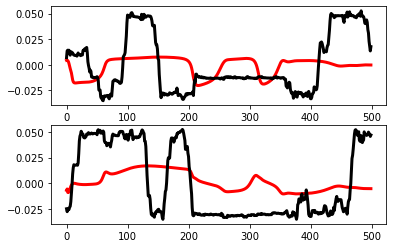

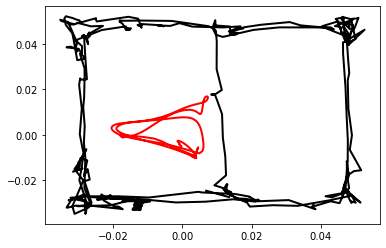

In [16]:
for x in batched_dataset.take(1):
    print(x.shape)
    qz_mean_est = vae.latent(x)
    print(qz_mean_est.shape)

qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
print(qz_est_norm[0].shape)

z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
print(z_true_norm.shape)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm[0]), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[0,:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[0,:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[0,:,0], qz_est_norm_R[0,:,1], lw=2, color = 'r')